#Cats and Dogs Classification
This notebook is to classify dogs and cats images via keras, SGD and neural network.

The dataset is collected from Kaggle (https://www.kaggle.com/c/dogs-vs-cats/overview).

We will be only using the **"train"** folder in the downloaded dataset.

Helpful reading of gradient descent optimization algorithms: [link](https://ruder.io/optimizing-gradient-descent/index.html#adam)

Understanding ReLU: [link](https://towardsdatascience.com/understanding-relu-the-most-popular-activation-function-in-5-minutes-459e3a2124f)

#Section 1: Environment Preparation

In [ ]:
# Set the random seed number for reproducible results
seedNum = 1

In [ ]:
# Set the TensorFlow version to 2.x in Colab
%tensorflow_version 2.x

In [ ]:
# Load Required libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot as plt
from matplotlib.image import imread
from datetime import datetime

In [ ]:
# Enable a GPU accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar  4 09:04:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	fig, axs = plt.subplots(2, 1, figsize=(12,12))
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	plt.legend()
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.legend()
	plt.show()

The learning curves will be used in section 3 when analyzing our CNN models.

In [ ]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#Section 2: Data Preparation

We will dowonload the required dataset through a external site.

It is a lot faster and save your local disk room.

In [ ]:
# Download and unzip the "train.zip" which we will be using for this project
# Estimate down load and unzip time: 30 seconds

!wget https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
!unzip train.zip > unzip_output.txt

--2022-03-04 09:04:27--  https://dainesanalytics.com/datasets/microsoft-kaggle-cats-and-dogs/train.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 108.159.227.93, 108.159.227.50, 108.159.227.35, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|108.159.227.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 543.16M  63.1MB/s    in 8.6s    

2022-03-04 09:04:36 (63.3 MB/s) - ‘train.zip’ saved [569546721/569546721]



Plot dog and cat photos from the dataset:



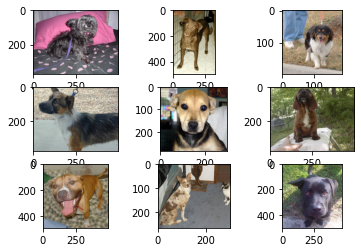

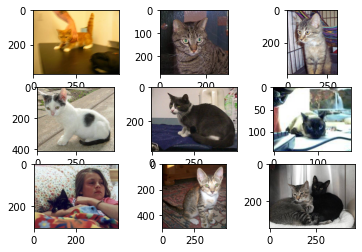

In [ ]:
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)

plt.show()

# Cats
for i in range(9): 
    plt.subplot(330 + 1 + i)    
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

**Pre-Process Photos into Standard Directories:**

Alternatively, you can load all the images using Keras Image data preprocessing, but will be slower to execute.

The API we are using for this project prefers the data to be organized into **train/** and **test/** directories.

The directories will be organized as below:
> dataset_dogs_vs_cats


*   train
  *   cats

  *   dogs


*   test
  *   cats

  *   dogs

In [ ]:
# organize dataset into a useful structure
from os import makedirs  # this is for creating directories
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

The following code will randomly select 25% of the images (6,250 images) to be used in a test dataset.

In [ ]:
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25 #25% of the images into the test dataset.

# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

After running the code, you can check the directories by clicking the "Files" on the left panel of colab. 

You should have a new **dataset_dogs_vs_cats/** now.


#Section 3: Develop a Baseline Convolutional Neural Network(CNN) Model

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

**VGG- Network** is a convolutional neural network model proposed by K.Simonyan and A.Zisserman in the paper [“Very Deep Convolutional Networks for Large-Scale Image Recognition”](https://arxiv.org/abs/1409.1556). This architecture achieved top-5 test accuracy of 92.7% in ImageNet, which has over 14 million images belonging to 1000 classes.
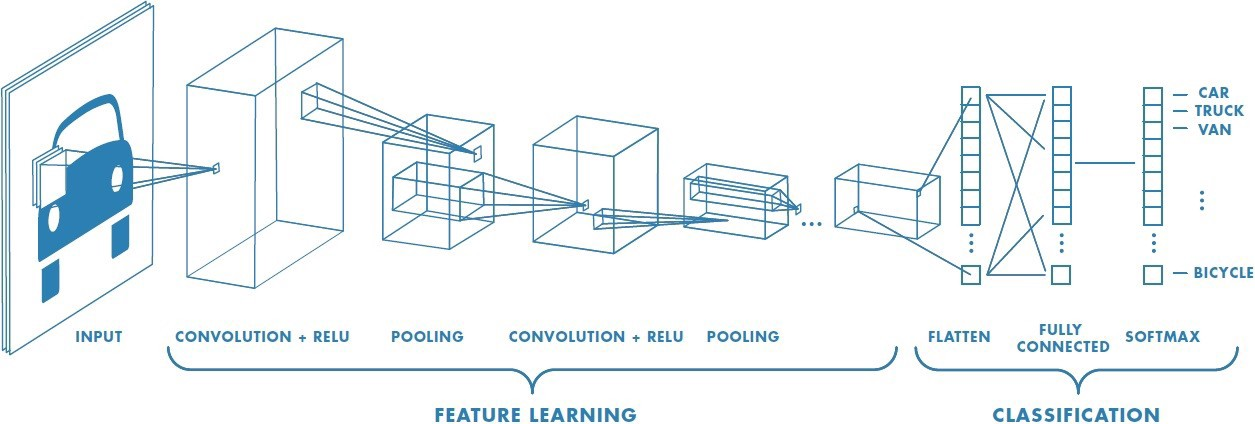

The architecture involves stacking **convolutional 2D layers** with small 3×3 filters followed by a **max pooling 2D layer**. Combining the two, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. **Padding** is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.


The main purpose of the activation function is to introduce the property of non-linearity into the model.
**ReLU** stands for **rectified linear activation function**, and it is a commonly used activation function by default for performing a majority of the deep learning tasks.

In here, we use **Stochastic Gradient Descent(SGD)** to build the model, which performs a parameter update for each training. 

The **learning rate** determines the size of the steps we take to reach the target. The **momentum** is a method that helps accelerate SGD in the relevant direction and dampens oscillations. We are using a conservative learning rate of 0.001 and a usual momentum of 0.9. 

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 73.124


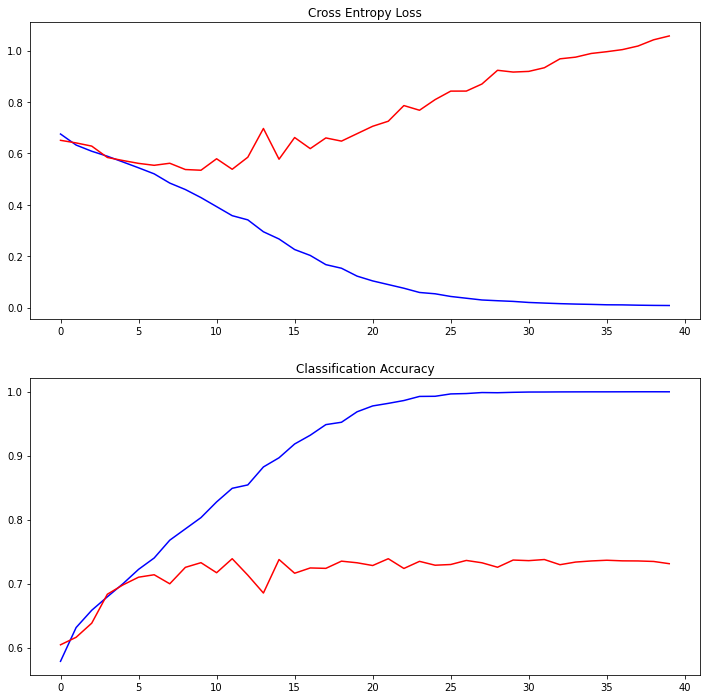

Total time for the model processing: 0:43:18.707244


In [ ]:
# baseline model with One Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0) # scale the pixel values to the range of 0-1.
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))  # batch size represents the amount of sample in one iteration.
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=0) # 1 epoch means the algorthium works through the entire training dataset once.
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

[**Cross-Entropy**](https://towardsdatascience.com/what-is-cross-entropy-3bdb04c13616) is a loss function that can be used to quantify the difference between two probability distributions. We calculate the cross-entropy by taking negative logs on probabilities of the event. Generally, the smaller the cross entropy is, the better the model will be.

Blue: Train dataset / Red: Test dataset

Reviewing the plots, the model has overfit the training dataset at about 7 epochs.


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 77.535


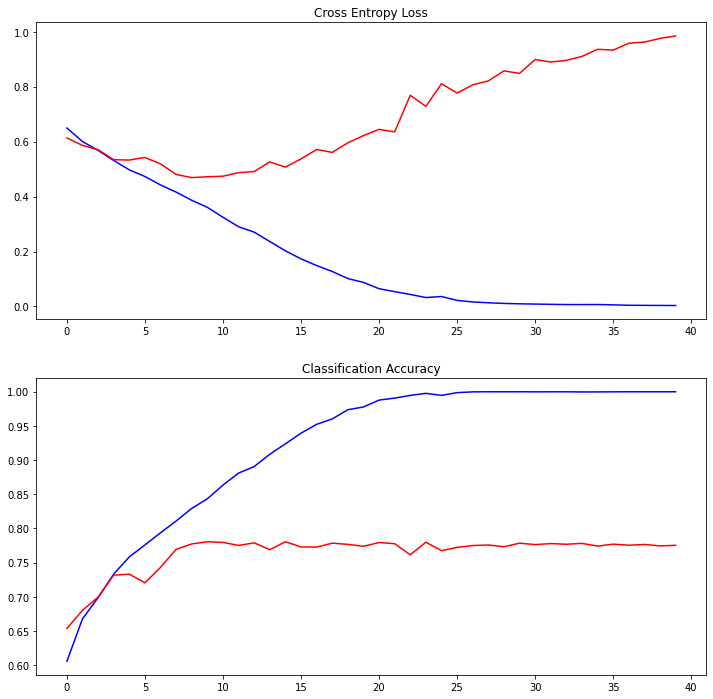

Total time for the model processing: 0:43:01.929421


In [ ]:
# baseline model with Two Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Blue: Train dataset / Red: Test dataset

Reviewing the plots, the model has overfit the training dataset at about 6 epochs.

Note: 
1. The average execution time is about 25 ~ 30 minutes.
2. When executing the Two or Three Block VGG Channel, sometimes an error will 
occur. You can either rerun it or keep executing, both ways would still let you get the result.
3. Your result may vary due to the fact that stochastic machine learning algorithms use randomness during learning, ensuring a different model is trained each run. 








Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 76.202


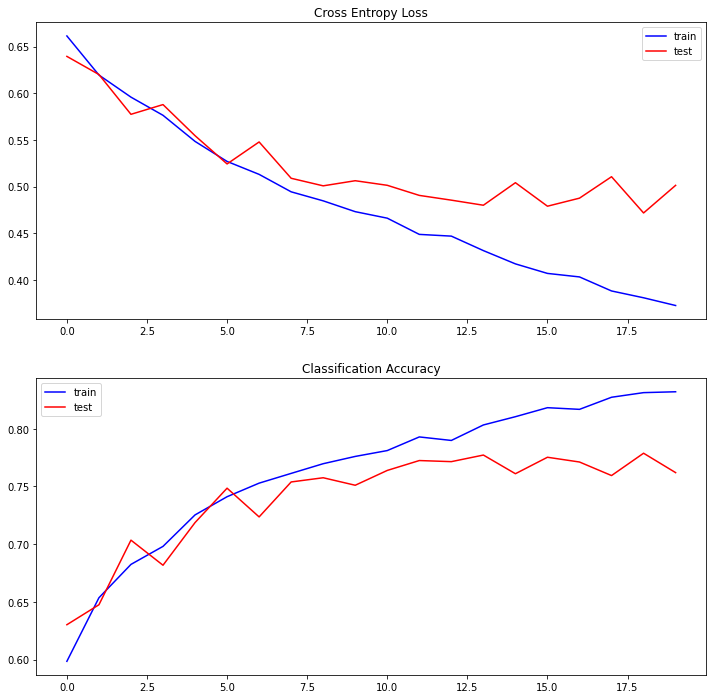

Total time for the model processing: 0:20:25.286757


In [ ]:
# baseline model with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1))) # try grayscale
	#model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# run the test harness for evaluating a model
def run_test_harness(model):
	# define model
	# model = define_model()
	model = model
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
		class_mode='binary', batch_size=64, target_size=(50, 50))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
		class_mode='binary', batch_size=64, target_size=(50, 50))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
model = define_model()
run_test_harness(model)
print('Total time for the model processing:', (datetime.now() - startTimeModule))

# Section 4: Dropout regularization

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/80
293/293 [==============================] - 78s 265ms/step - loss: 0.7347 - accuracy: 0.5107 - val_loss: 0.6916 - val_accuracy: 0.5574
Epoch 2/80
293/293 [==============================] - 77s 263ms/step - loss: 0.6881 - accuracy: 0.5298 - val_loss: 0.6893 - val_accuracy: 0.5355
Epoch 3/80
293/293 [==============================] - 76s 261ms/step - loss: 0.6816 - accuracy: 0.5505 - val_loss: 0.6890 - val_accuracy: 0.5266
Epoch 4/80
293/293 [==============================] - 76s 258ms/step - loss: 0.6754 - accuracy: 0.5663 - val_loss: 0.6840 - val_accuracy: 0.5323
Epoch 5/80
293/293 [==============================] - 75s 258ms/step - loss: 0.6658 - accuracy: 0.5830 - val_loss: 0.6799 - val_accuracy: 0.5409
Epoch 6/80
293/293 [==============================] - 75s 256ms/step - loss: 0.6593 - accuracy: 0.5897 - val_loss: 0.6758 - val_accuracy: 0.5580
Epoch 7/80
293/293 [=========================

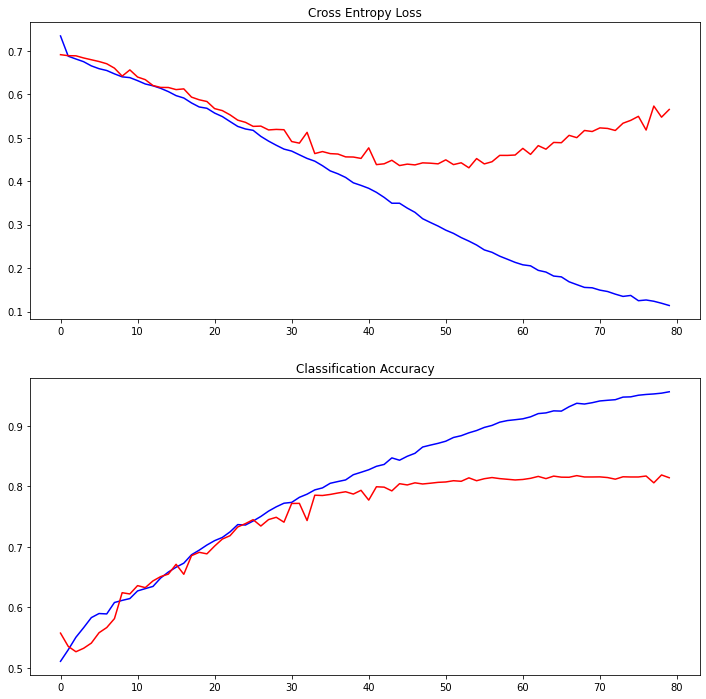

Total time for the model processing: 1:38:21.176044


In [ ]:
# dropout regularization with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=80, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

# Section 5: Image Data Augmentation

In [ ]:
#Image Augmentation Showcase

datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.3,
                             rotation_range=30, horizontal_flip=True)
i = 0
for batch in datagen.flow_from_directory('showcase/',color_mode='rgb',
                  batch_size=18, save_to_dir='showcase/output', 
                  save_prefix = 'out', save_format='jpeg'):
  i+=1
  if i ==1:
    break

Found 18 images belonging to 3 classes.


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/180
293/293 [==============================] - 84s 255ms/step - loss: 0.6784 - accuracy: 0.5753 - val_loss: 0.6403 - val_accuracy: 0.6332
Epoch 2/180
293/293 [==============================] - 74s 253ms/step - loss: 0.6340 - accuracy: 0.6405 - val_loss: 0.5928 - val_accuracy: 0.6844
Epoch 3/180
293/293 [==============================] - 74s 253ms/step - loss: 0.6030 - accuracy: 0.6752 - val_loss: 0.5719 - val_accuracy: 0.7109
Epoch 4/180
293/293 [==============================] - 74s 253ms/step - loss: 0.5681 - accuracy: 0.7057 - val_loss: 0.5424 - val_accuracy: 0.7306
Epoch 5/180
293/293 [==============================] - 74s 254ms/step - loss: 0.5513 - accuracy: 0.7211 - val_loss: 0.5194 - val_accuracy: 0.7471
Epoch 6/180
293/293 [==============================] - 74s 254ms/step - loss: 0.5426 - accuracy: 0.7294 - val_loss: 0.4980 - val_accuracy: 0.7576
Epoch 7/180
293/293 [==================

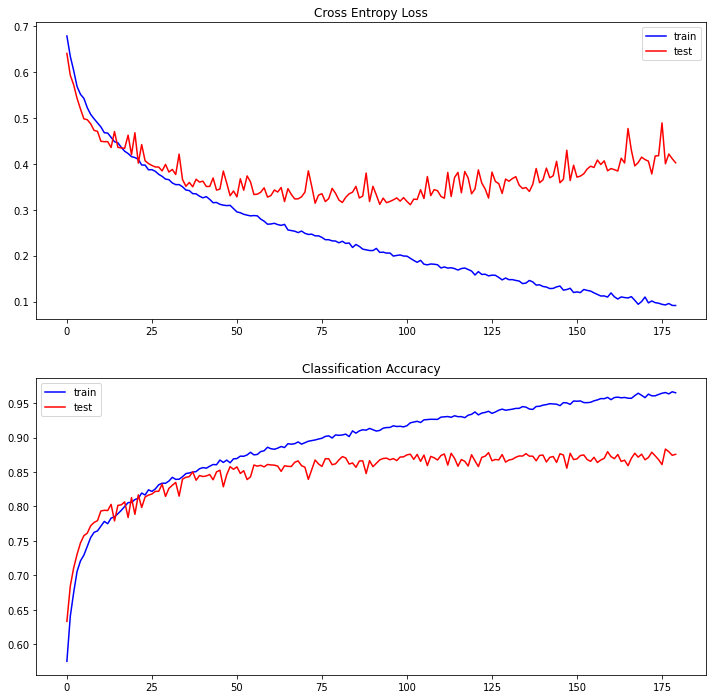

Total time for the model processing: 3:43:50.012690


In [ ]:
# image data augmentation with Three Block VGG Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#run the test harness for evaluating a model
def run_test_harness(model):
  # define model
  #model = define_model()
  model = model
  # create data generator
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    width_shift_range=0.1, shear_range=0.2, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(100, 100))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=180, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)

# entry point, run the test harness
model = define_model()
run_test_harness(model)
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/100
293/293 [==============================] - 101s 307ms/step - loss: 0.6832 - accuracy: 0.5599 - val_loss: 0.6572 - val_accuracy: 0.6178
Epoch 2/100
293/293 [==============================] - 88s 302ms/step - loss: 0.6502 - accuracy: 0.6241 - val_loss: 0.6713 - val_accuracy: 0.5743
Epoch 3/100
293/293 [==============================] - 87s 298ms/step - loss: 0.6293 - accuracy: 0.6443 - val_loss: 0.6053 - val_accuracy: 0.6679
Epoch 4/100
293/293 [==============================] - 87s 297ms/step - loss: 0.5985 - accuracy: 0.6778 - val_loss: 0.5975 - val_accuracy: 0.6719
Epoch 5/100
293/293 [==============================] - 87s 297ms/step - loss: 0.5720 - accuracy: 0.7004 - val_loss: 0.5345 - val_accuracy: 0.7362
Epoch 6/100
293/293 [==============================] - 87s 297ms/step - loss: 0.5484 - accuracy: 0.7223 - val_loss: 0.5282 - val_accuracy: 0.7390
Epoch 7/100
293/293 [=================

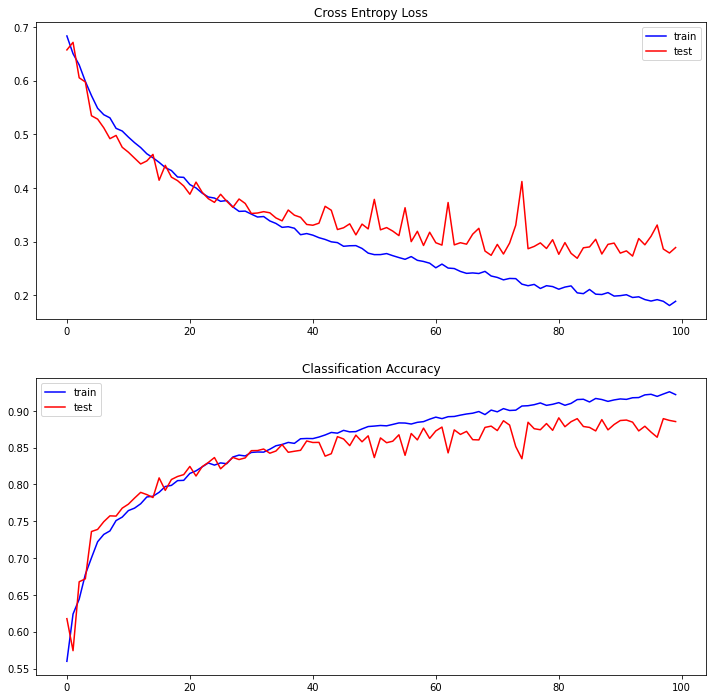

Total time for the model processing: 2:28:09.316386


In [ ]:
# Combination of dropout and image augmentation
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(80, 80, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(80, 80, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(80, 80, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(80, 80, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model:
  opt = SGD(learning_rate=0.003, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

#run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generator
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    shear_range=0.1, rotation_range=30, horizontal_flip=True)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterator
  train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(80, 80))
  test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/', color_mode='grayscale',
    class_mode='binary', batch_size=64, target_size=(80, 80))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=100, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))


#Section 6: Transfer Learning Using VGG-16 Model from Keras API

**Transfer learning** is a technique in machine learning that using established knowledge to solve similar problems. For example, the algorithm that learned to recognize bicycles can be apply to recognize motorcycles, since they have similar patterns.

This model can be found in [Keras API Applications page](https://keras.io/api/applications/)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

58900480/58889256 [==============================] - 0s 0us/step
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 98s 328ms/step - loss: 0.2281 - accuracy: 0.9636 - val_loss: 0.0670 - val_accuracy: 0.9737
Epoch 2/10
293/293 [==============================] - 95s 325ms/step - loss: 0.0262 - accuracy: 0.9906 - val_loss: 0.0720 - val_accuracy: 0.9735
Epoch 3/10
293/293 [==============================] - 95s 324ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0788 - val_accuracy: 0.9764
Epoch 4/10
293/293 [==============================] - 95s 325ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0844 - val_accuracy: 0.9748
Epoch 5/10
293/293 [==============================] - 95s 324ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0912 - val_accuracy: 0.9759
Epoch 6/10
293/293 [==============================] - 95s 323ms/step - loss: 7.3627e-04 - accuracy: 0.9999 - val_loss: 0.0931

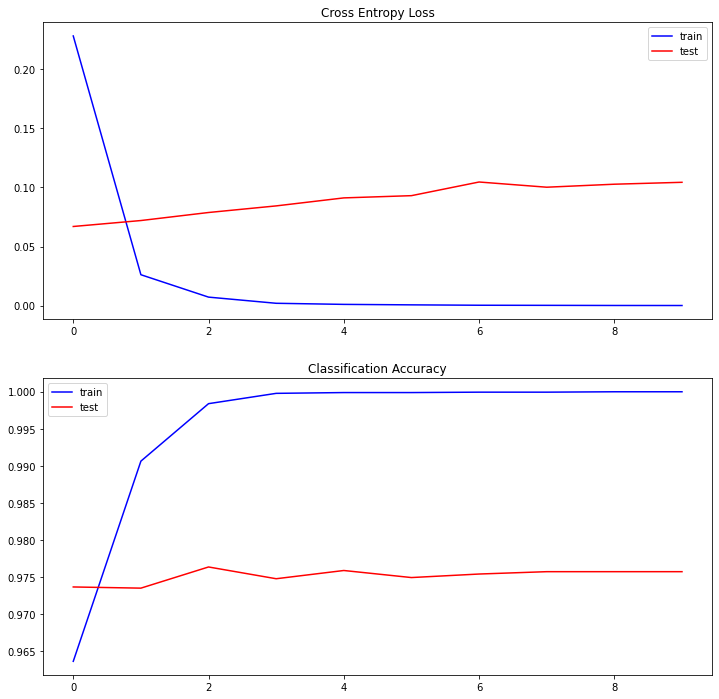

Total time for the model processing: 0:17:06.477801


In [ ]:
# Transfer learning with VGG16 Model
startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

#define CNN model
def define_model():
  #load model
  # we do not load the fully-connected output layers (which make prediction)
  model = VGG16(include_top=False, input_shape=(224,224,3)) 
  # freeze the laoded layers from VGG16 as untrainable
  for layer in model.layers:
    layer.trainable = False

  #add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  #define new model
  model = Model(inputs=model.inputs, outputs=output)
  #compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

  #run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(featurewise_center=True)
  # specify mean values for centering (from imagenet)
  datagen.mean = [123.68, 116.779, 103.939]
  # prepare iterator
  train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
    class_mode='binary', batch_size=64, target_size=(224, 224))
  test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
    class_mode='binary', batch_size=64, target_size=(224, 224))
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
  #evaluate model
  _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

#Section 7: Let's Make Prediction

In [ ]:
# organize the final dataset
from os import makedirs
from os import listdir
from shutil import copyfile

#create directories
dataset = 'predict_cats_vs_dogs/'

#create label
labeldirs = ['cats/', 'dogs/']
for labldir in labeldirs:
  newdir = dataset + labldir
  makedirs(newdir, exist_ok = True)

#copy training dataset images into subdirectories
src_directory = 'train'
for file in listdir(src_directory):
  src = src_directory + '/' + file
  if file.startswith('cat'):
    dst = dataset + 'cats/' + file
    copyfile(src, dst)
  elif file.startswith('dog'):
    dst = dataset + 'dogs/' + file
    copyfile(src, dst)

Save the final model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
# save the final model to file

startTimeModule = datetime.now()
tf.random.set_seed(seedNum)

#define CNN model
def define_model():
  #load model
  model = VGG16(include_top=False, input_shape=(224,224,3)) #default value
  # freeze the laoded layers from VGG16 as untrainable
  for layer in model.layers:
    layer.trainable = False

  #add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  #define new model
  model = Model(inputs=model.inputs, outputs=output)
  #compile model
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

  #run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(featurewise_center=True)
  # specify mean values for centering (from imagenet)
  datagen.mean = [123.68, 116.779, 103.939]
  # prepare iterator
  train_it = datagen.flow_from_directory('predict_cats_vs_dogs/',
    class_mode='binary', batch_size=64, target_size=(224, 224))
  # fit model
  model.fit(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
  # save model
  model.save('final_prediction.h5')

# entry point, run the test harness
run_test_harness()
print('Total time for the model processing:', (datetime.now() - startTimeModule))

Found 25000 images belonging to 2 classes.
Total time for the model processing: 0:14:41.969019


In [ ]:
from IPython.display import Image, display

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

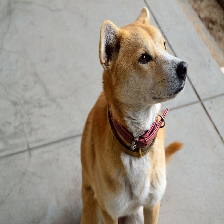

In [ ]:
img = load_img('sample.jpg', target_size=(224,224))
img

In [ ]:
#load the image we want to predict
def load_image(filename):
  img = load_img(filename, target_size=(224,224))
  # convert img to array
  img = img_to_array(img)
  # reshape into a single sample with 3 channels
  img = img.reshape(1, 224, 224, 3) #(batch_size, height, width, color_channels)
  # center pixel data
  img = img.astype('float32')
  img = img - [123.68, 116.779, 103.939]  # mean BGR values
  return img

def run_prediction():
  img = load_image('sample.jpg')
  model = load_model('final_prediction.h5')
  result = model.predict(img)
  if result[0] == 0:
    print('It is a cat.')
  elif result[0] == 1:
    print('It is a dog.')

run_prediction()

It is a dog.
